# Semantic Segmentation of Smoke in GOES Satellite Imagery

## Dataset Learning Notebook
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/reykoki/Smoke_Semantic_Segmenation_Learning_Notebook/blob/main/Dataset.ipynb)

**Learning Notebook 1 of 2**


---

**Author:** Rey Koki (CIRES / NOAA GSL)  
**Contact:** rey.koki@noaa.gov  
**Acknowledgments:** This work was supported by the NOAA National Centers for Environmental Information (NCEI).

---

## Overview
This notebook provides a step-by-step guide for creating a machine learning ready dataset of smoke in GOES satellite imagery. It walks users through downloading HMS smoke annotations and corresponding ABI L1b imagery, processing the data with SatPy, and aligning the annotations with satellite composites. Designed for researchers and practitioners, the notebook emphasizes clarity and reproducibility. It enables users to generate high-quality training data for smoke detection and segmentation models.

### Prerequisites

- Basic Python knowledge
- Familiarity with satellite imagery and geospatial data is helpful but not required
- Internet access for downloading data
- Recommended to run in [Google Colab](https://colab.research.google.com) or a Jupyter environment with at least 8GB RAM

### Learning Outcomes

By the end of this notebook, you will be able to:
1. Download and visualize [HMS smoke annotations](https://www.ospo.noaa.gov/Products/land/hms.html).
2. Retrieve corresponding [GOES ABI L1b satellite imagery](https://registry.opendata.aws/noaa-goes/) using AWS S3.
3. Use [SatPy](https://satpy.readthedocs.io/en/latest/) to generate RGB composites.
4. Project HMS smoke plumes onto satellite imagery.
5. Explore and prepare a machine-learning-ready dataset for smoke segmentation.


### Time Estimate
* Estimated text reading time: 10 to 30 min
* Estimated code reading time: 20 to 40 min
* Estimated total reading time: 30 to 70 min

In [1]:
import os

# Check if running inside Google Colab by comparing current working directory
if os.getcwd() == '/content':
    print("You are working in a Google Colab notebook!\nLet's grab the data and code from GitHub.\n")    
    # Remove any existing directories to avoid conflicts
    !rm -r Get_GOES scripts figures data   
    # Clone the Smoke Semantic Segmentation Learning Notebook repository
    !git clone git@github.com:reykoki/Smoke_Semantic_Segmenation_Learning_Notebook.git    
    # Remove the Dataset notebook from the cloned repo to avoid duplicates
    !rm Smoke_Semantic_Segmenation_Learning_Notebook/Dataset.ipynb    
    # Move all files from the cloned repo into the current working directory
    !mv Smoke_Semantic_Segmenation_Learning_Notebook/* .    
    # Install required dependencies listed in requirements.txt
    !pip install -r requirements.txt



In [2]:
# Import Python libraries
import matplotlib.pyplot as plt
import numpy as np
import skimage
from glob import glob
import os
import time
from datetime import datetime
import wget
import pytz
import sys

# Add the './scripts' directory to the Python path to allow custom module imports
sys.path.insert(1, './scripts')
# Import all helper functions from helper_functions.py (in ./scripts)
from helper_functions import *

## 1. HMS Smoke Annotations
NOAA's [Hazard Mapping System (HMS)](https://www.ospo.noaa.gov/Products/land/hms.html) provides daily human-annotated smoke plumes derived from GOES satellite imagery.

These annotations are distributed as shapefiles. In this section, you'll learn how to retrieve and view HMS data using `geopandas`.

Below is the most recent HMS smoke plume map:

![HMS Map](https://www.ospo.noaa.gov/data/land/fire/currenthms.jpg)

### 1.1 Select Date and Time
Use the format `YYYY/MM/DD HH:MM` to select the imagery UTC time of interest.

In [4]:
# Define the target date and UTC time as a string
dt_str = '2024/06/18 15:00'

# Convert the string to a datetime object and localize it to UTC
dt = pytz.utc.localize(datetime.strptime(dt_str, '%Y/%m/%d %H:%M'))

sunrise on the west coast is at 13:31 UTC for 2024/06/18
sunset on the east coast is at 03:10 UTC for 2024/06/19
DOWNLOADING SMOKE:
hms_smoke20240618.zip
./data/smoke/hms_smoke20240618.zip
hms_smoke20240618.zip already exists

there are 6 smoke annotations in the time period requested


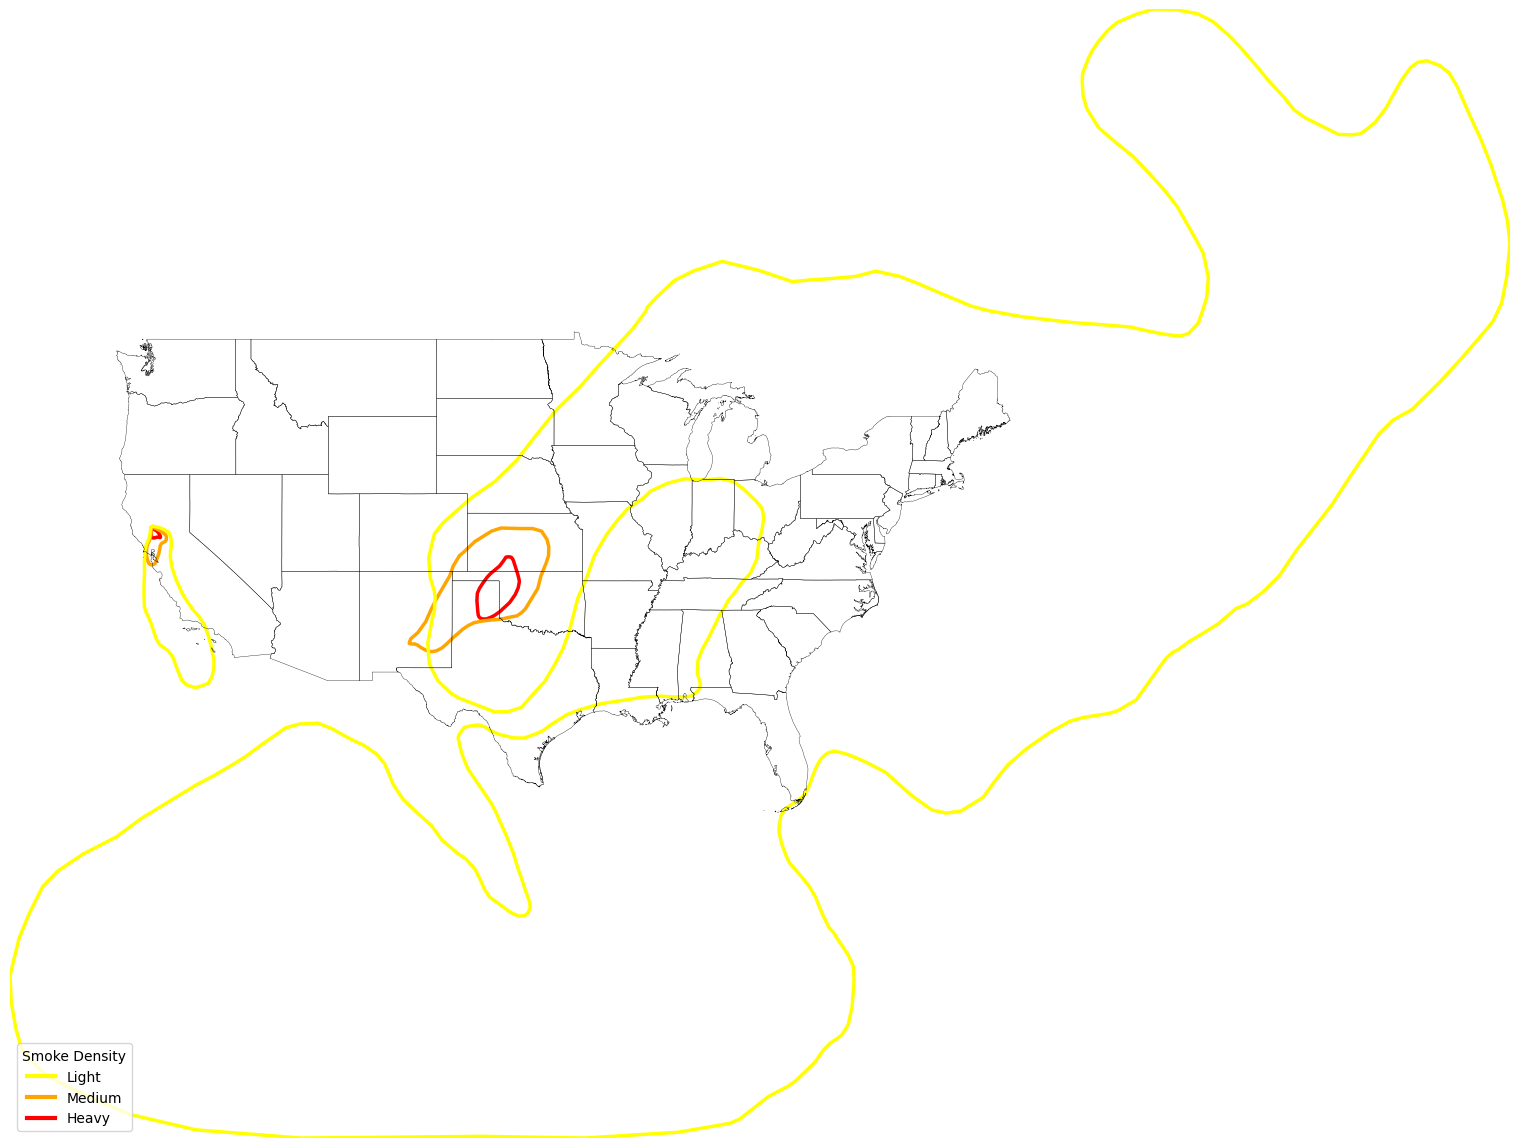

In [6]:
# Import the function for downloading HMS smoke plume shapefiles
# The function is defined in ./scripts/grab_smoke.py
from grab_smoke import download_smoke

# Download the smoke plume shapefile for the specified datetime (dt)
# This function retrieves NOAA HMS smoke annotations and saves them locally
# Returns a Python geodataframe extracted from the shapefile
smoke_shp = download_smoke(dt)

Using [geopandas](https://geopandas.org/en/stable/) we can convert the .shp files into python geopandas GeoDataFrame object so that the data can be easily accessed.

In [8]:
print(type(smoke_shp))
display(smoke_shp.head())

<class 'geopandas.geodataframe.GeoDataFrame'>


Satellite         Start           End Density  \
1   GOES-EAST  2024170 1230  2024170 1700   Light   
8   GOES-EAST  2024170 1230  2024170 1700  Medium   
18  GOES-EAST  2024170 1230  2024170 1700   Heavy   
0   GOES-WEST  2024170 1200  2024170 1530   Light   
9   GOES-EAST  2024170 1230  2024170 1700  Medium   

                                             geometry  
1   POLYGON ((-122.49294 39.35240, -122.53282 39.2...  
8   POLYGON ((-105.69097 33.24046, -105.60033 33.2...  
18  POLYGON ((-100.98606 34.51616, -100.81608 34.5...  
0   POLYGON ((-102.58308 28.14229, -102.45342 27.6...  
9   POLYGON ((-122.49476 39.31933, -122.50609 39.1...

## 2. GOES Satellite Imagery

For a more in-depth overview of GOES imagery, refer to the [GOES-R Series Data Book](https://www.goes-r.gov/downloads/resources/documents/GOES-RSeriesDataBook.pdf).

### 2.1. Bands
To create a true color image, we use the following bands from the Advanced Baseline Imager Level 1b CONUS (ABI-L1b-RadC) product.

| Band | Descirption | Center Wavelength ($\mu$m) | Spatial Resolution (km) |
| :-: | :-: | :-: | :-: |
| C01 | Blue visible | 0.47 | 1 |
| C02 | Red visible | 0.64 | 0.5 |
| C03 | Veggie near infrared | 0.865 | 1 |

A new ABI-L1b-RadC data file is produced every 5 minutes from both GOES-East and GOES-West and provided in netCDF4 format. 

![GOES-16](https://cdn.star.nesdis.noaa.gov/GOES16/ABI/CONUS/GEOCOLOR/GOES16-CONUS-GEOCOLOR-625x375.gif "GOES")

In [15]:
# Import the function for downloading GOES satellite data
# The function is defined in ./scripts/grab_goes.py
from grab_goes import download_goes

# Download GOES ABI band files for the specified datetime (dt)
# This function retrieves C01, C02 and C03 GOES-East data (NetCDF format) from AWS
# and returns a list of local file paths to the downloaded files
# In addition, it will print out sunrise and sunset for the given day
sat_fns = download_goes(dt)

for the datetime 2024-06-18 15:00:00+00:00:
sunrise is at: 2024-06-18 13:31:12+00:00
sunset is at: 2024-06-18 00:37:48+00:00
OR_ABI-L1b-RadC-M6C01_G16_s20241701501183_e20241701503556_c20241701503589.nc already exists
OR_ABI-L1b-RadC-M6C02_G16_s20241701501183_e20241701503556_c20241701503581.nc already exists
OR_ABI-L1b-RadC-M6C03_G16_s20241701501183_e20241701503556_c20241701504003.nc already exists


## 3. Use Satpy to process GOES satellite imagery (ABI L1b)

#### ***NOTE:*** running this will take a few minutes

### 3.1 True Color Composite

We use [SatPy](https://satpy.readthedocs.io/en/stable/) to generate a CIMSS True Color composite from GOES ABI L1b imagery. This composite applies several corrections to produce a realistic, human-visible view of the atmosphere. For more information, see the [CIMSS True Color paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018EA000379) and [quick guide](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_CIMSSRGB_v2.pdf).

The composite includes:
- **True color adjustment**: simulates natural color using channels C01, C02, and C03.
- **Solar zenith correction**: adjusts for changes in lighting due to the sun’s angle relative to the Earth's surface.
- **Rayleigh scattering correction**: accounts for wavelength-dependent scattering by atmospheric particles.


In [16]:
composite = ['cimss_true_color_sunz_rayleigh'] # define the true color composite

### 3.2. Lambert Conformal Conic Projection

We reproject the image to a [Lambert conformal conic projection](https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection) to reduce spatial distortion caused by the [geostationary projection](https://proj.org/en/9.2/operations/projections/geos.html).

In [17]:
import cartopy.crs as ccrs
# Define a function to return a Lambert Conformal Conic (LCC) projection
def get_proj():
    lcc_proj = ccrs.LambertConformal(
        central_longitude=262.5,        # Centered roughly on central CONUS
        central_latitude=38.5,          # Standard parallel and projection center latitude
        standard_parallels=(38.5, 38.5),# True at 38.5°N; reduces distortion near this latitude
        globe=ccrs.Globe(               # Define Earth shape with spherical approximation
            semimajor_axis=6371229,
            semiminor_axis=6371229     # Use spherical Earth model (radius in meters)
        )
    )
    return lcc_proj

# Define the extent of the projected image in meters [x_min, x_max, y_min, y_max]
# Covers the Continental U.S. in the Lambert Conformal projection
extent = [-2.4e6, -1.5e6, 2.3e6, 1.4e6]

### 3.3. Get Satpy Scene Object

After the satellite files have been downloaded, we load them into a SatPy `Scene` object for processing.

We then use the `create_area_def` function from Pyresample to define the projection, spatial resolution, and geographic extent for resampling.

In [18]:
from satpy import Scene
from pyresample import create_area_def

# Define a function to create a Satpy Scene and resample it to a custom projection and resolution
def get_scn(fns, to_load, extent, res=3000, proj=get_proj(), reader='abi_l1b', print_info=False):
    # Create a Scene object with the specified reader and list of file paths
    scn = Scene(reader=reader, filenames=fns)
    
    # Load the specified datasets or composites (without generating them yet)
    scn.load(to_load, generate=False)
    
    # Define a custom area using the provided projection, resolution (in meters), and extent
    my_area = create_area_def(
        area_id='my_area',
        projection=proj,
        resolution=res,
        area_extent=extent
    )
    
    # Optionally print available datasets and composite names in the Scene object
    if print_info:
        print("Available channels in the Scene object:\n", scn.available_dataset_names())
        print("\nAvailable composites:\n", scn.available_composite_names())
        print("\nArea definition:\n", my_area)
    
    # Resample the Scene data to the defined area; returns a new Scene object
    new_scn = scn.resample(my_area)
    return new_scn

# Set the target spatial resolution (in kilometers per pixel)
res = 5000  # 5 km resolution

# Load and resample the GOES imagery into a Satpy Scene object
scn = get_scn(sat_fns, composite, extent, res, print_info=True)

# Extract the Cartopy CRS for plotting from the first composite layer
crs = scn[composite[0]].attrs['area'].to_cartopy_crs()

Available channels in the Scene object:
 ['C01', 'C02', 'C03']

Available composites:
 ['cimss_green', 'cimss_green_sunz', 'cimss_green_sunz_rayleigh', 'cimss_true_color', 'cimss_true_color_sunz', 'cimss_true_color_sunz_rayleigh', 'color_infrared', 'green', 'green_crefl', 'green_nocorr', 'green_raw', 'true_color', 'true_color_crefl', 'true_color_nocorr', 'true_color_raw', 'true_color_reproduction', 'true_color_reproduction_corr', 'true_color_reproduction_uncorr']

Area definition:
 Area ID: my_area
Description: my_area
Projection: {'R': '6371229', 'lat_0': '38.5', 'lat_1': '38.5', 'lat_2': '38.5', 'lon_0': '262.5', 'no_defs': 'None', 'proj': 'lcc', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 940
Number of rows: 580
Area extent: (-2400000.0, -1500000.0, 2300000.0, 1400000.0)


rsr data may not be up to date: /home/mecr8410/.local/share/pyspectral/rsr_abi_GOES-16.h5
6kB [00:00, 3233.85kB/s]             


#### 3.3.1. Get RGB from Scene Object

#### ***NOTE:*** running this will take a few minutes

In [19]:
from satpy.writers import get_enhanced_image

# Extract and format RGB image data from the Scene object for plotting
def get_RGB(scn, composite):
    # Apply Satpy's enhancement pipeline to get display-ready RGB data (e.g., True Color)
    RGB = get_enhanced_image(scn[composite]).data.compute().data  # Dask array → NumPy array

    # Reorder dimensions from (bands, height, width) to (height, width, bands) for plotting
    RGB = np.einsum('ijk->jki', RGB)

    # Replace NaN values with 0 (black) for cleaner display
    RGB[np.isnan(RGB)] = 0

    return RGB

# Generate RGB data array from the specified composite in the Scene object
RGB = get_RGB(scn, composite[0])

/projects/mecr8410/software/anaconda/envs/alps/lib/python3.12/site-packages/dask/_task_spec.py:745: RuntimeWarning: invalid value encountered in cos
  return self.func(*new_argspec)
/projects/mecr8410/software/anaconda/envs/alps/lib/python3.12/site-packages/dask/_task_spec.py:745: RuntimeWarning: invalid value encountered in sin
  return self.func(*new_argspec)
/projects/mecr8410/software/anaconda/envs/alps/lib/python3.12/site-packages/dask/_task_spec.py:745: RuntimeWarning: invalid value encountered in cos
  return self.func(*new_argspec)
/projects/mecr8410/software/anaconda/envs/alps/lib/python3.12/site-packages/dask/_task_spec.py:745: RuntimeWarning: invalid value encountered in sin
  return self.func(*new_argspec)
/projects/mecr8410/software/anaconda/envs/alps/lib/python3.12/site-packages/satpy/composites/__init__.py:1405: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(av_data.reshape(new_shape), axis=(1, 3))


## 4. Project HMS smoke annotations onto GOES imagery

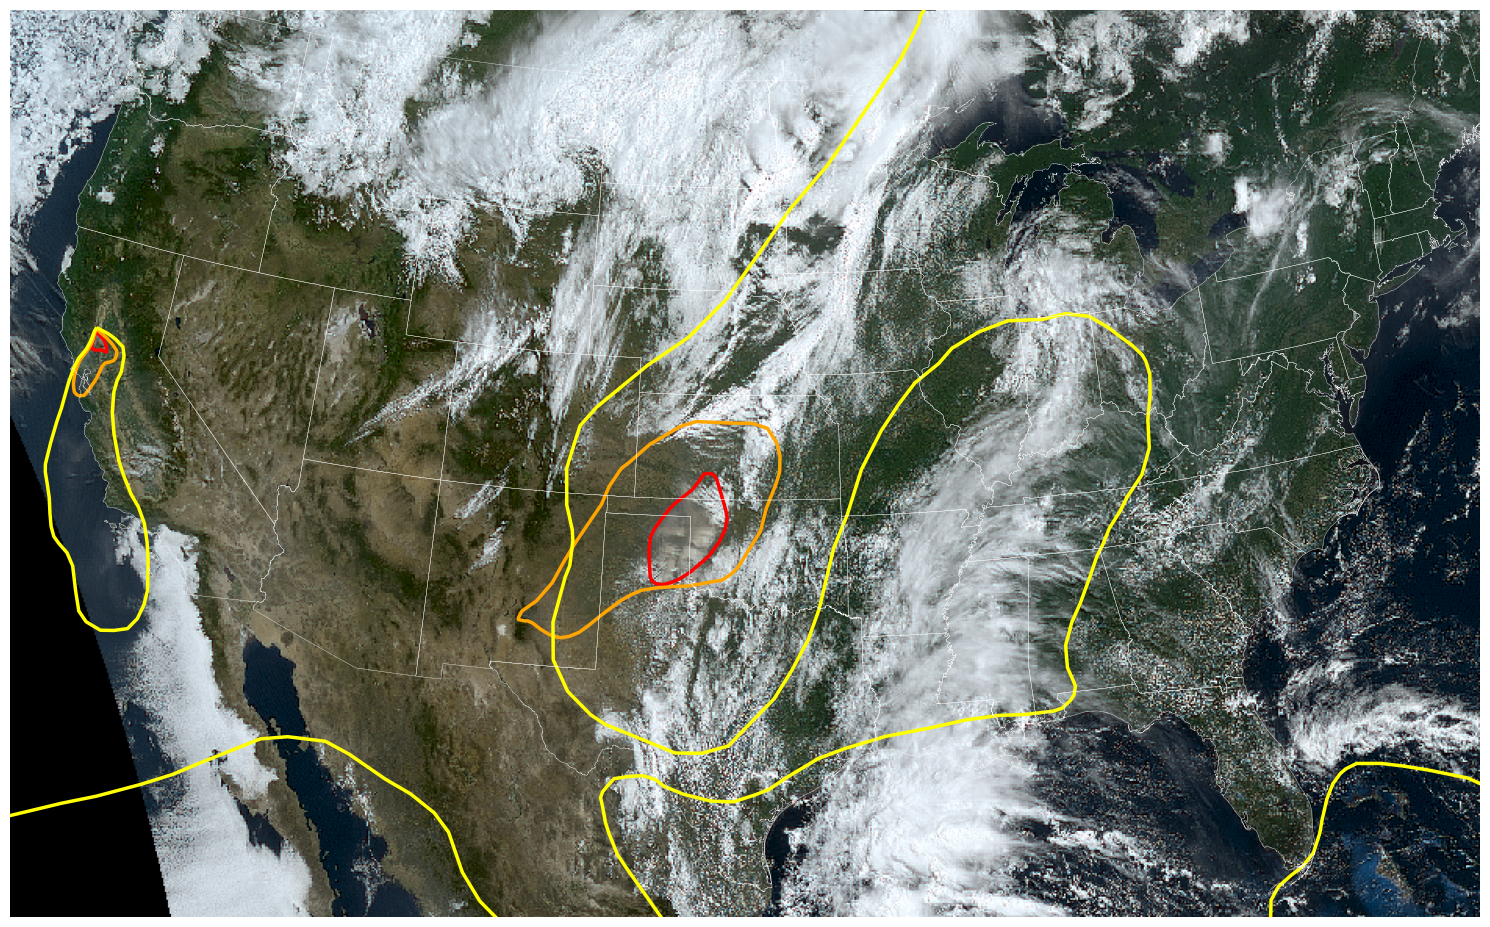

In [20]:
# Plot the CONUS GOES True Color image with smoke plume annotations overlaid
def plot_CONUS_Smoke(data, crs, smoke):
    # Load US state boundaries reprojected to the specified CRS
    states = get_states(crs)  # Function located in ./scripts/helper_functions.py

    # Reproject the smoke plume shapefile to match the CRS of the GOES imagery
    smoke = smoke.to_crs(crs)

    # Create a figure and axis using the provided CRS (Lambert Conformal Conic)
    fig = plt.figure(figsize=(15, 12))
    ax = plt.axes(projection=crs)

    # Display the GOES True Color data
    plt.imshow(data, transform=crs, extent=crs.bounds, origin='upper')

    # Overlay state boundaries for geographic context
    states.boundary.plot(ax=ax, edgecolor='white', linewidth=0.25)

    # Plot smoke plumes with colors corresponding to density levels
    smoke.loc[smoke['Density'] == 'Heavy'].plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2.5)
    smoke.loc[smoke['Density'] == 'Medium'].plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=2.5)
    smoke.loc[smoke['Density'] == 'Light'].plot(ax=ax, facecolor='none', edgecolor='yellow', linewidth=2.5)

    # Remove axis ticks and labels for a clean map
    plt.axis('off')
    fig.tight_layout()

    # Optionally save the plot (currently commented out)
    # plt.savefig('conus.png')

    # Display the plot
    plt.show()

# Example usage: Plot the GOES RGB data with smoke shapefile overlays
plot_CONUS_Smoke(RGB, crs, smoke_shp)

## 5. Visualize machine learning data and labels

The full-resolution 1 kilometer, 3-channel CONUS satellite imagery contains approximately 180 million pixels. Larger image sizes increase the computational cost of training and running machine learning models. To improve efficiency, we work with downsampled images of around 200,000 pixels, which reduces spatial coverage to 250 km².

### 5.1. Define filename from dataset

In [21]:
# Filename for a GOES-derived .tif image.
# The name encodes the satellite (G16 = GOES-16), start and end scan times, and HMS smoke ID.
fn = 'G16_s20232680016174_e20232680018547_22.tif'

#### 5.1.1. plot RGB

2023/09/25 00:16 UTC


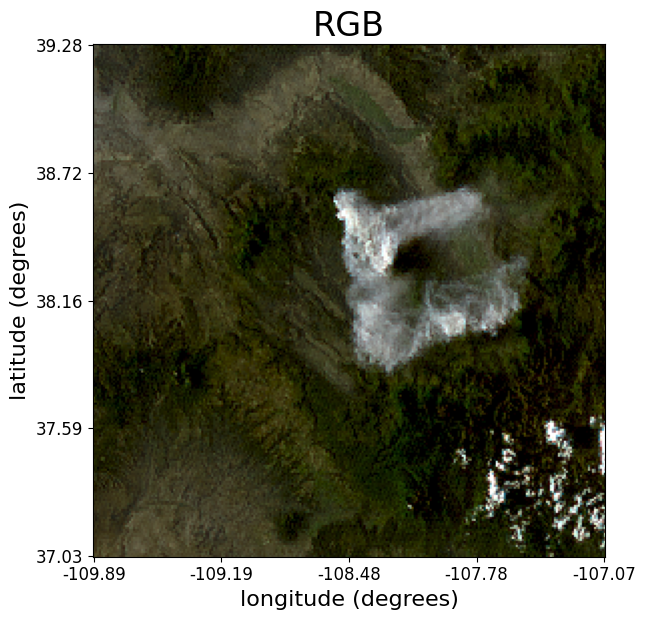

In [22]:
# Import plotting functions from the local script ./scripts/plot_tifs.py
from plot_tifs import plot_RGB,  plot_densities_from_processed_data, plot_R_G_B, plot_labels # code located in /scripts/plot_tifs.py
# Plot the RGB composite from the specified GOES .tif file
plot_RGB(fn)

#### 5.1.2. Plot RGB channels

The "green" channel is approximated using a combination of the red, blue and veggie bands.

G16_s20232680016174_e20232680018547_22.tif
center lat, lon: (38.31, -108.66)


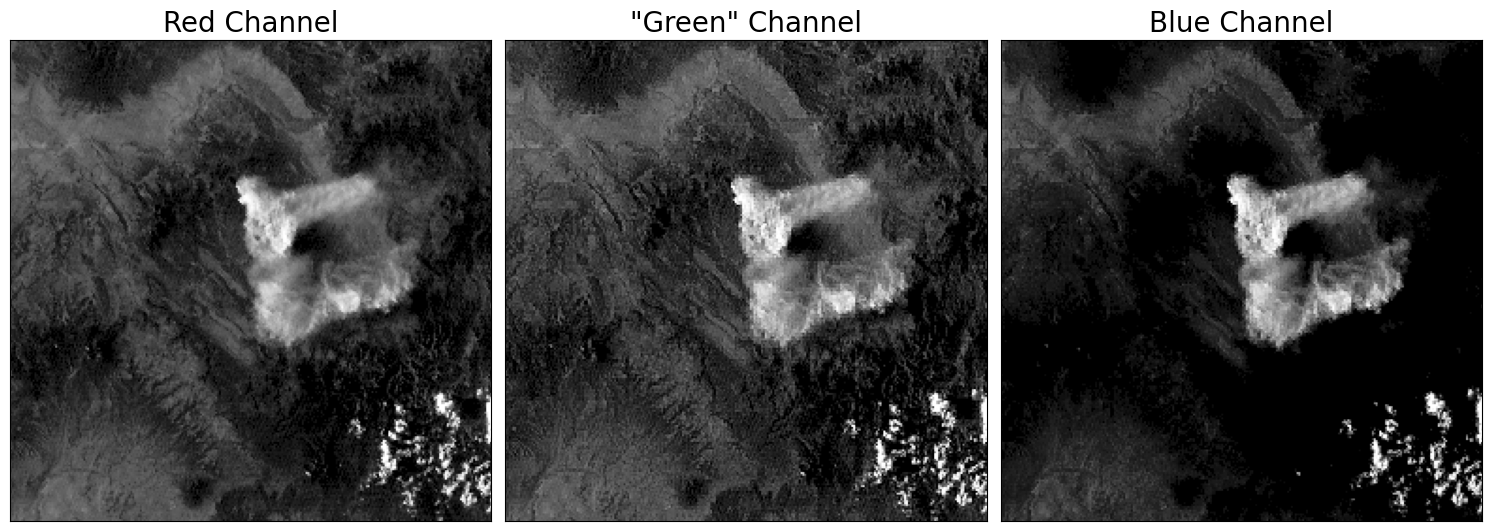

In [23]:
# plot_R_G_B: Plots the individual Red, "Green", and Blue channels separately
plot_R_G_B(fn)

#### 5.1.3. Plot Smoke Densities

The labels are divided into 3 layers for each smoke density.

G16_s20232680016174_e20232680018547_22.tif


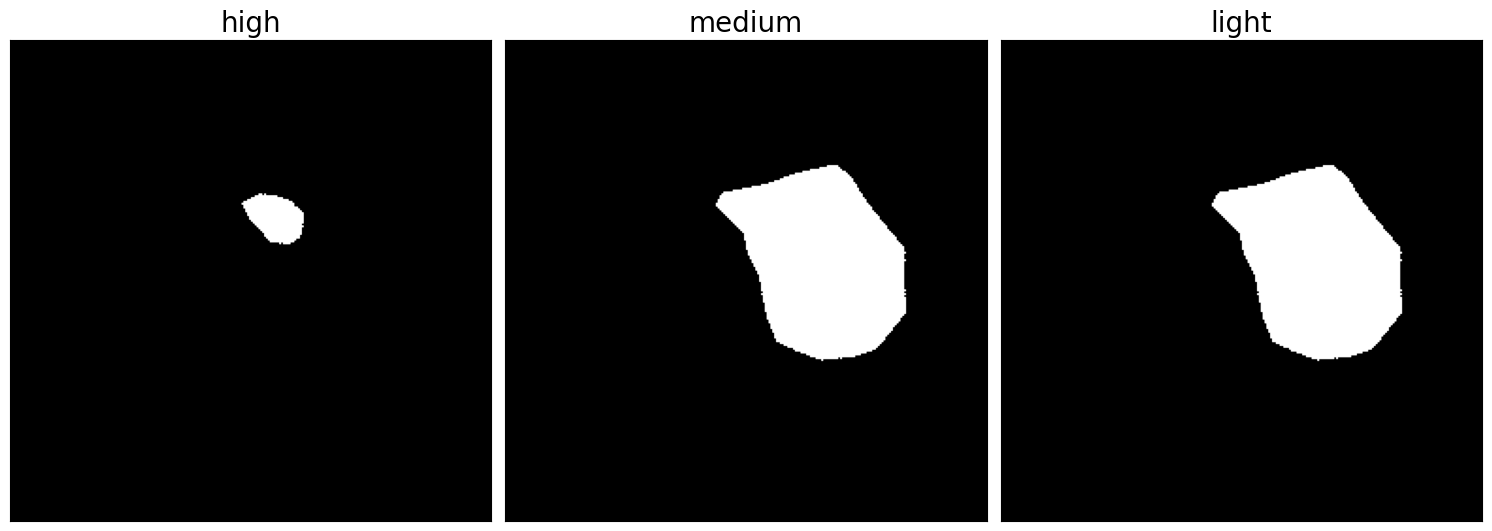

In [24]:
# plot_labels: Displays labeled data (e.g., smoke annotations)
plot_labels(fn)

#### 5.1.3 Plot Smoke Densities on Top of GOES Data

Red, orange and yellow polygons correspond to high, medium and light smoke densities.

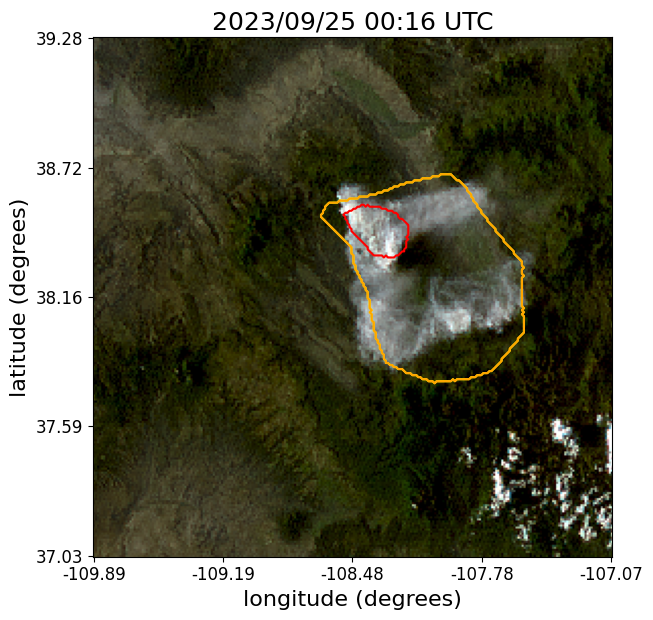

In [25]:
#plot_densities_from_processed_data: smoke density levels projected on GOES True Color
plot_densities_from_processed_data(fn)

## 6. Download Sample Dataset From Zenodo

In [18]:
import zipfile    # For extracting .zip files
import wget       # For downloading files from the internet

# Prompt the user to decide whether to download the larger dataset (1.3 GB)
download = input('Do you want to download the larger 1.3 GB dataset? [y/n]')

# If the user responds with 'y' or 'Y', download and extract the dataset
if download == 'y' or download == 'Y':
    # Download the zipped dataset from Zenodo
    wget.download("https://zenodo.org/records/10946629/files/sample_dataset.zip?download=1")

    # Define the path to the downloaded .zip file
    path_to_zip = "sample_dataset.zip"

    # Extract all contents of the zip file into the current directory
    with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
        zip_ref.extractall('.')

do you want to download the larger 1.3 GB dataset? [y/n] y


## Exercises

Try the following to reinforce your understanding:
1. Select a different date/time and visualize HMS smoke annotations.
2. Create a new area definition for a region of interest.

## Next Steps

Now that you’ve prepared a machine-learning-ready dataset:
- Proceed to the [segmentation notebook](https://github.com/reykoki/Smoke_Semantic_Segmenation_Learning_Notebook/blob/main/Machine_Learning.ipynb)
- Explore how the model architecture is built and trained
- Experiment with inference using your own imagery

## Data Statement

- HMS annotations are produced by NOAA analysts and made available at [OSPO](https://www.ospo.noaa.gov/Products/land/hms.html).
- GOES ABI Level 1b data is publicly hosted by NOAA on [AWS Open Data](https://registry.opendata.aws/noaa-goes/).

## References

SatPy Developers, 2024: SatPy Documentation. https://satpy.readthedocs.io.

GOES-R Program Office, 2024: GOES-R Series Overview. NOAA, https://www.goes-r.gov.

Bah, M. K., M. M. Gunshor, and T. J. Schmit, 2018: Generation of GOES‑16 True Color Imagery without a Green Band. Earth and Space Science, 5, 549–558, doi:10.1029/2018EA000379.

## Disclaimer and License

This Jupyter notebook is a scientific product and is not official communication of the National Oceanic and Atmospheric Administration, or the United States Department of Commerce. All NOAA Jupyter notebooks are provided on an 'as is' basis and the user assumes responsibility for its use. Any claims against the Department of Commerce or Department of Commerce bureaus stemming from the use of this Jupyter notebook will be governed by all applicable Federal law. Any reference to specific commercial products, processes, or services by service mark, trademark, manufacturer, or otherwise does not constitute or imply their endorsement, recommendation or favoring by the Department of Commerce. The Department of Commerce seal and logo, or the seal and logo of a DOC bureau, shall not be used in any manner to imply endorsement of any commercial product or activity by DOC or the United States Government.

